## Summary of the results

I have run just 15 experiments, in other words, this is not an exhaustive search of the parameter space. As with most of the other algorithms in this repo, I simply wanted to illustrate the functioning of the algorithm and show some results. 

All the experiments are in the `run_experiments.sh` file.

Let's have a look

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from plot_utils import highlight_greaterthan, plot_loss
from pathlib import Path

In [3]:
DATA_PATH = Path("results")
fname = "results_df.csv"

In [4]:
df_results = pd.read_csv(DATA_PATH/fname)

In [5]:
thresholds = [df_results['recall@20'].max(), df_results['ndcg@20'].max()]
columns = ['recall@20', 'ndcg@20']

In [7]:
(df_results
 .sort_values('modelname', ascending=False)
 .reset_index(drop=True)
 .style.apply(highlight_greaterthan, threshold=thresholds, column=columns, axis=1))

,modelname,loss,epoch,precision@20,precision@40,precision@60,precision@80,precision@100,recall@20,recall@40,recall@60,recall@80,recall@100,ndcg@20,ndcg@40,ndcg@60,ndcg@80,ndcg@100,hit_ratio@20,hit_ratio@40,hit_ratio@60,hit_ratio@80,hit_ratio@100
0,"ngcf_adj_norm_opt_adam_nemb_64_layers_[64,64]_messdr_0.0_reg_0.0.pt",1.78477,99,0.0100286,0.00789126,0.00671131,0.00597037,0.00541739,0.0782008,0.119892,0.149954,0.175779,0.197485,0.0593788,0.0761572,0.087074,0.095852,0.102932,0.162206,0.234785,0.284229,0.323822,0.355897
1,"ngcf_adj_norm_opt_adam_nemb_32_layers_[32,32]_messdr_0.0_reg_0.0.pt",3.95769,99,0.00856083,0.0068385,0.00589814,0.00527337,0.00480849,0.0662023,0.103069,0.1317,0.154867,0.174948,0.0508989,0.0661256,0.0765775,0.0846405,0.0912316,0.141304,0.208454,0.25668,0.294071,0.324129
2,"ngcf_adj_norm_opt_adam_nemb_16_layers_[16,16]_messdr_0.0_reg_0.0.pt",10.4564,99,0.00711399,0.00577202,0.00503496,0.00455318,0.00418514,0.0535578,0.0854175,0.110621,0.132149,0.150931,0.0424721,0.0558925,0.0653381,0.0729285,0.0791866,0.119353,0.179937,0.224306,0.260205,0.289795
3,"ngcf_adj_norm_opt_RAdam_nemb_64_layers_[64,64]_messdr_0_reg_0_lr_01_lrs_No.pt",4.48744,13,0.00701799,0.00572221,0.00500632,0.00453463,0.00416957,0.0535486,0.0854428,0.111165,0.133058,0.151773,0.041882,0.0553697,0.0649185,0.0725691,0.0788379,0.118369,0.179413,0.224564,0.260915,0.290691
4,"ngcf_adj_norm_opt_RAdam_nemb_64_layers_[64,64]_messdr_0_reg_0_lr_003_lrs_No.pt",0.726657,99,0.00914327,0.00713597,0.00609619,0.00540366,0.00490255,0.0730689,0.110174,0.138527,0.161483,0.180858,0.0561003,0.0713132,0.0817375,0.0896352,0.0961257,0.150226,0.216772,0.264464,0.300791,0.330461
5,"ngcf_adj_norm_opt_Adam_nemb_64_layers_[64,64]_messdr_5_reg_0_lr_005_lrs_No.pt",1.0452,68,0.00584745,0.00463859,0.00401958,0.00360378,0.00329897,0.0465294,0.0710566,0.0902519,0.106077,0.120016,0.0373977,0.0481196,0.0556073,0.0614645,0.066358,0.0999839,0.14837,0.184213,0.212399,0.236036
6,"ngcf_adj_norm_opt_Adam_nemb_64_layers_[64,64]_messdr_3_reg_0_lr_003_lrs_No.pt",1.04205,73,0.00755445,0.00599488,0.00513513,0.00456891,0.00417102,0.0599196,0.091652,0.115781,0.135601,0.153226,0.0469527,0.060357,0.069381,0.0763228,0.082237,0.125726,0.185657,0.227469,0.260213,0.288061
7,"ngcf_adj_norm_opt_Adam_nemb_64_layers_[64,64]_messdr_1_reg_0_lr_002_lrs_No.pt",0.875995,99,0.00904647,0.00705833,0.0060221,0.00535979,0.00487036,0.0716209,0.108004,0.135516,0.158495,0.177902,0.0550392,0.0700129,0.0801774,0.0881431,0.0946532,0.147556,0.213327,0.259608,0.295837,0.325742
8,"ngcf_adj_norm_opt_Adam_nemb_64_layers_[64,64]_messdr_0_reg_0_lr_01_lrs_CyclicLR.pt",8.41605,8,0.00658358,0.00534991,0.00470367,0.00424976,0.00391747,0.0507804,0.081247,0.105601,0.126244,0.144463,0.0403987,0.0531684,0.0622929,0.0694716,0.0755428,0.112359,0.170749,0.213746,0.248136,0.277138
9,"ngcf_adj_norm_opt_Adam_nemb_64_layers_[64,64]_messdr_0_reg_0_lr_003_lrs_ReduceLROnPlateau.pt",0.827517,99,0.00914247,0.00714606,0.00609377,0.00541878,0.00491368,0.0721121,0.109218,0.13706,0.16027,0.179617,0.0560905,0.0713082,0.0815229,0.089547,0.0959678,0.149347,0.216384,0.26244,0.299226,0.328178


### Model nomenclature

Let me pick a couple examples and use them to describle the `modelname` meaning. Note that the name for the first 3 is slightly less detailed than that from the 4th in advance, where I also added information on whether I used a learning rate scheduler and the learning rate itself. 

Let's go:

* `ngcf_adj_norm_opt_adam_nemb_64_layers_[64,64]_messdr_0.0_reg_0.0.pt`: run with the model `Neural Graph Collaborative Filtering` (could also be `bpr`. See the `ngcf.py` file), with the adjacency matrix option `norm`, with `Adam` optimizer, 64 dim embeddings, plus 2 "graph" layers with 64 units each, no message dropout, and no regularization applied to the BPR loss.   
* `ngcf_adj_norm_opt_Adam_nemb_64_layers_[64,64]_messdr_0_reg_0_lr_01_lrs_CyclicLR.pt`: it reads mostly the same as before, but here I have started with a learning rate of 0.01 (only the decimals are in the name) and I have used a `CyclicLR` learnign rate scheduler (`lrs`)

And I'd say that with these is trivial to read the remaining experiments. As I mentioned in the begining of the notebook, I have not run an exhausting search of the parameter space. 

If you wanted to do that, then you should use a validation set. To do that simply run:

    python data_preparation.py --valid 1

This will generate a 80-20 train/test split and, out of the 80% used for training, it will further split 90-10 train-validation. Then, within `run.py`, simply set `val` to `True` when defining the `data_generator`, like this:

    ...
    data_generator = Data(path=data_dir + dataset, batch_size=batch_size, val=True)
    ...
    
and that's it. The rest of the code/run is identical.

### Static vs Dynamic

Another aspect worth mentioning is that all recorded experiments are run with a huge `batch_size` of 8192. This is because if you look at the forward pass of the algorithm, you will see that the batch size only matters here:

    u_emb = u_g_embeddings[u]
    p_emb = i_g_embeddings[i]
    n_emb = i_g_embeddings[j]

i.e. slicing the graph embeddings. Other than that, each forward pass executes a graph that involves *"all"* items and users. Therefore, in reality, one could use any batch_size (as long as it fits in memory). I have chosen 8192, but could be 8192$\times$2 or 8192/2. The bigger the batch size the faster, of course.

The fact that in each forward pass one needs to execute such huge graph is the reason why I believe this algorithm in particular is better suited for Tensorflow than Pytorch. When using static graphs (TF) you construct the graph just once and then is executed in each forward pass as you pass the data (i.e. define-and-run). However, when using dynamic graphs (Pytorch), the graph will have to be built **and** executed in each forward pass (i.e. define-by-run). Therefore, the only way for Pytorch to be competitive with TF here is to decrease the maximum possible the amount of forward passes per epoch, i.e. use large batches. Still, the [original TF](https://github.com/xiangwang1223/neural_graph_collaborative_filtering) implementation by the authors of the [paper](https://arxiv.org/pdf/1905.08108.pdf) is significantly faster than my Pytorch implementation.

I also tried to use `jit` and compile the model code to a static representation. However, I came into all sorts of problems, like the fact that you can't use `ModuleList` or that strings have to be `"string literal"` when using `setattr` or `getattr`. I managed to solve all that but then I hit this: `RuntimeError: sparse tensors not supported`, which was "the end of the road" for the `jit` experimentation, since I do need sparse tensors here. 

### The Results

Let's now simply have a look to the results in the table. Note that I have included in the table an `epoch` column. This column shows the epoch at which the run stopped. I run all but one experiment with 100 epochs. Therefore, for those experiments for which this column has a value of 99, it means that the algorithm was still learning and more epochs would be required. 

You will see that the best performing experiment (`ngcf_adj_norm_opt_Adam_nemb_64_layers_[64,64]_messdr_0_reg_0_lr_001_lrs_ReduceLROnPlateau.pt`) has a value of 3 at that column. This value is meaningless for that particular experiment. In this particular case what I did was the following. I took the best performing experiment at that time (`ngcf_adj_norm_opt_adam_nemb_64_layers_[64,64]_messdr_0.0_reg_0.0.pt`) and run it for 500 epochs. I also used a `ReduceLROnPlateau` learning rate scheduler so that if the evaluation metrics did not improve in 10 epochs the learning rate would decrease by a factor of 10. Unfortunately, my EC2 instance stop working at around 4am to the point that I could not ssh into it (`ssh_exchange_identification: read: connection reset by peer`). I had to reboot the machine and start the experiment with the `--pretrain 1` option. This means that even though I saved the model weights, I lost the information on at which point, in these 500 epochs, the run stopped. The only thing I know is that, the next morning, when I re-started the training, after 3 extra epochs the algorithm *"early stopped"*, and hence the 3 in that column, but might as well be 133...  

### Loss vs Ranking Metrics

You will see that, in terms of `loss`, the experiment using RAdam achieves the best results in the least amount of epochs. This is consistent with some remarkable examples that people is finding 'out there'. However, let me use this opportunity to mentione again that when evaluating recommendation algorithms, `loss` might not be the best meassure of success. For a more detailed discussion on the evaluation of recommendation algorithms please read [this notebook](https://github.com/jrzaurin/RecoTour/blob/master/Amazon/neural_cf/Chapter05_results_summary.ipynb) and references therein. Let's just have a look to some plots.

In [8]:
Ks = [20, 40, 60, 80, 100]
metrics = ['precision', 'recall', 'hit_ratio', 'ndcg']
metrics_cols = []
for m in metrics:
    col =  pd.concat([df_results['@'.join([m, str(k)])] for k in Ks], ignore_index=True)
    metrics_cols.append(col)

In [9]:
df_loss = pd.concat([pd.DataFrame(c) for c in metrics_cols], axis=1)
df_loss.columns = metrics

In [10]:
df_loss['loss'] = df_results.loss.tolist() * 5
df_loss['k'] = [k for k in Ks for _ in range(15)]

In [12]:
df_loss.head(30)

,precision,recall,hit_ratio,ndcg,loss,k
0,0.007114,0.053558,0.119353,0.042472,10.456439,20
1,0.008561,0.066202,0.141304,0.050899,3.957692,20
2,0.010029,0.078201,0.162206,0.059379,1.784770,20
3,0.009142,0.072112,0.149347,0.056091,0.827517,20
4,0.006584,0.050780,0.112359,0.040399,8.416048,20
5,0.007018,0.053549,0.118369,0.041882,4.487437,20
6,0.007569,0.058485,0.126751,0.045155,3.810512,20
7,0.009143,0.073069,0.150226,0.056100,0.726657,20
8,0.009046,0.071621,0.147556,0.055039,0.875995,20
9,0.007554,0.059920,0.125726,0.046953,1.042053,20


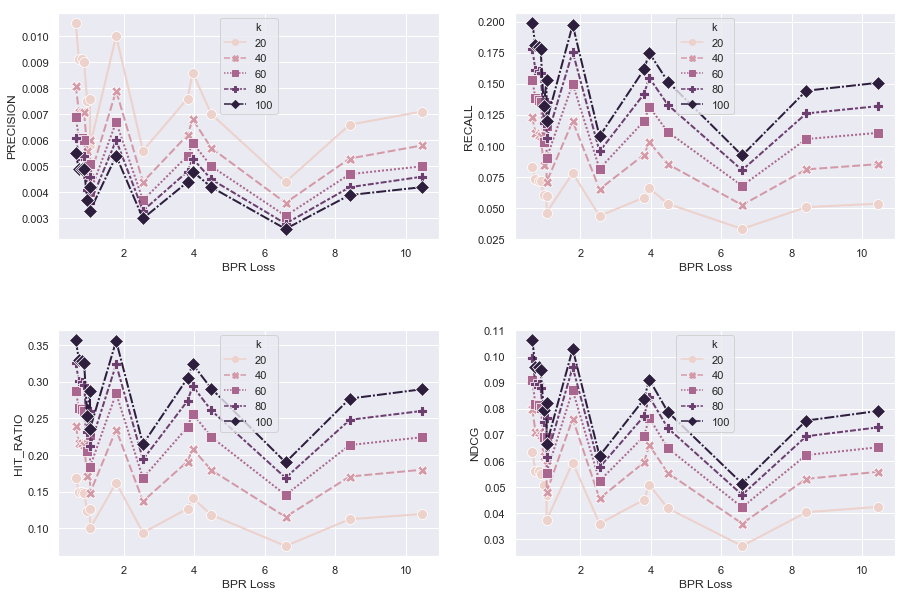

In [13]:
plot_loss(df_loss)

This Figure shows the Ranking Metrics vs BPR Loss for the 15 experiments run, for the different values of k. We can see that, even though there is a trend for the ranking metrics to improve when BPR decreases, lower BPR loss values do not alwats imply better ranking metric between different models. Again, if you want to learn/read a bit more go to [this notebook](https://github.com/jrzaurin/RecoTour/blob/master/Amazon/neural_cf/Chapter05_results_summary.ipynb) or directly to this [book](https://www.amazon.co.uk/Recommender-Systems-Textbook-Charu-Aggarwal/dp/3319296574/ref=sr_1_1?crid=2SK7PGNMA59FW&keywords=recommender+systems&qid=1559762483&s=gateway&sprefix=recommender+syste%2Caps%2C153&sr=8-1). 

And for now, this is it. NGCF added to the repo. Hopefully there will be more algorithms soon!